# IBM Capstone Project

### This notebook is for the Capstone project from IBM provided through Coursera.

In [2]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

## Retrieving wikipage and extracting data into a dataframe

In [3]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
page_soup = BeautifulSoup(source, 'lxml')
print(page_soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of postal codes of Canada: M - Wikipedia
  </title>
  <script>
   document.documentElement.className = document.documentElement.className.replace( /(^|\s)client-nojs(\s|$)/, "$1client-js$2" );
  </script>
  <script>
   (window.RLQ=window.RLQ||[]).push(function(){mw.config.set({"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"List_of_postal_codes_of_Canada:_M","wgTitle":"List of postal codes of Canada: M","wgCurRevisionId":876823784,"wgRevisionId":876823784,"wgArticleId":539066,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Communications in Ontario","Postal codes in Canada","Toronto","Ontario-related lists"],"wgBreakFrames":false,"wgPageContentLanguage":"en","wgPageContentModel":"wikitext","wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wg

By inspecting the wiki page we can see that the desired data is under the table > tbody > tr > td tags.
Using BeautifulSoup, we can extract all tags the 'td' tags to obtain the table values and append it to a list which
is then used to sort the values into their respective categories. However, it also extracts unwanted data from a
second table at the bottom of the wiki page. But because that table is small we can simplify the code by just
slicing it out of the lists.

In [4]:
data = []
for e in page_soup.find_all('td'):
    data.append(e.text)
    
postcode = data[0::3][:-12:]
borough = data[1::3][:-11:]
neighbourhoods = data[2::3][:-11:]

In [5]:
len(postcode), len(borough), len(neighbourhoods) # checking the num of values to make sure they are the same

(289, 289, 289)

In [6]:
df = pd.DataFrame({'Postcode': postcode, 'Borough': borough, 'Neighbourhoods': neighbourhoods})
df['Neighbourhoods'] = df['Neighbourhoods'].str.replace(r'\n', '') # removing the nextline character for neighbourhoods
df.head()

,Postcode,Borough,Neighbourhoods
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


## Data cleaning

Remove Borough values that are 'Not assigned' as they are not usefull. This will also remove samples that have both Borough and Neighbourhoods that are labeled 'Not assigned' as no neighbourhoods will be assigned if Borough's are not assigned but the opposite is not true.

In [7]:
df = df[df['Borough'] != 'Not assigned'].reset_index(drop=True)
df.head()

,Postcode,Borough,Neighbourhoods
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


In [8]:
print(f"num of samples: {len(df)}\n")
print(f"unique postcodes: {df['Postcode'].nunique()}")
print(f"unique boroughs: {df['Borough'].nunique()}")

num of samples: 212

unique postcodes: 103
unique boroughs: 11


Next we group the postcode and boroughs while joining the neighbourhoods with commas

In [9]:
df_grp = df.groupby(['Postcode', 'Borough']).agg(lambda x: ', '.join(x)).reset_index()
df_grp.head()

,Postcode,Borough,Neighbourhoods
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Check the number of samples and unique postcodes after grouping

In [10]:
print(f"num of samples: {len(df_grp)}\n")
print(f"unique postcodes: {df_grp['Postcode'].nunique()}")
print(f"unique boroughs: {df_grp['Borough'].nunique()}")

num of samples: 103

unique postcodes: 103
unique boroughs: 11


Find and replace all values in column "Neighbourhoods" that is labeled "Not assigned" with values from their respective "Borough".

In [11]:
df_grp[df_grp['Postcode'] == 'M7A'] # taking a 'before' operation sample 

,Postcode,Borough,Neighbourhoods
85,M7A,Queen's Park,Not assigned


In [12]:
for i in df_grp.index[df_grp['Neighbourhoods'] == 'Not assigned'].tolist():
    df_grp.loc[i, 'Neighbourhoods'] = df_grp.loc[i, 'Borough']

In [13]:
df_grp[df_grp['Postcode'] == 'M7A'] # 'after' operation sample

,Postcode,Borough,Neighbourhoods
85,M7A,Queen's Park,Queen's Park


Number of samples in final df

In [14]:
len(df_grp)

103

In [15]:
df_grp.head()

,Postcode,Borough,Neighbourhoods
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


## Find lat and long of neighbourhoods

Attempting with geocoder

In [16]:
import geocoder # import geocoder

In [17]:
#df_grp[df_grp['Postcode'] == 'M6R']

In [18]:
#postal_code = 'M6R'
#g = geocoder.google('{}, Toronto, Ontario'.format(postal_code), sensor=False)
#print(g)
#lat_lng_coords = g.latlng

Unfortunately, geocoder does not work as the request was denied on Google's end. Thus, we will get the lat and long from the csv provided instead.

In [19]:
coor = pd.read_csv('Geospatial_Coordinates.csv')

In [20]:
coor.head(10)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029
7,M1L,43.711112,-79.284577
8,M1M,43.716316,-79.239476
9,M1N,43.692657,-79.264848


In [21]:
df_1 = df_grp.merge(coor, left_on='Postcode', right_on='Postal Code', how='inner').drop(columns=['Postal Code'])

In [22]:
df_1.head(10)

,Postcode,Borough,Neighbourhoods,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


## Exploring and Clustering

In [23]:
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import folium
import requests
import matplotlib.pyplot as plt
%matplotlib notebook

%load_ext line_profiler
%load_ext memory_profiler

In [24]:
df_1['Borough'].value_counts()

North York          24
Downtown Toronto    18
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
York                 5
East York            5
East Toronto         5
Queen's Park         1
Mississauga          1
Name: Borough, dtype: int64

### Visualising the zipcodes

In [27]:
place = 'Toronto, Ontario, Canada'

geolocator = Nominatim(user_agent='maple_syrup')
location = geolocator.geocode(place)
lat = location.latitude
long = location.longitude
print(f"Coordinates for Toronto: {[lat, long]}")

Coordinates for Toronto: [43.653963, -79.387207]


In [28]:
def basemap(lat, long, zoom_start=10, control_scale=True):
    bmap = folium.Map([lat, long], control_scale=control_scale, zoom_start=zoom_start)
    
    return bmap

In [55]:
toronto_map = basemap(lat, long, zoom_start=10)

for lat, long, postcode in zip(df_1['Latitude'], df_1['Longitude'], df_1['Postcode']):
    label = folium.Popup(postcode)
    folium.CircleMarker([lat, long], radius=5, popup=label, color='green', fill=True, fill_color='green', fill_opacity=0.8).add_to(toronto_map)
    
toronto_map

### Exploring the area with FourSquare

The following function gets the top 100 venues around a 500m radius for each zipcode using the FourSquare API and put it in a dataframe. The user will need to use their own client_id and client_secret.

In [35]:
def get_all_venues(name, lat, lon, radius=500, Limit=100):
    
    places = []
    
    for name, lat, lon in zip(name, lat, lon):
        
        print(name)
        
        CLIENT_ID = 'CLIENT_ID' # your Foursquare ID
        CLIENT_SECRET = 'CLIENT_SECRET' # your Foursquare Secret
        VERSION = '20190220' # Foursquare API version

        radius = radius
        url = 'https://api.foursquare.com/v2/venues/explore'
        params = dict(client_id=CLIENT_ID, client_secret=CLIENT_SECRET, v=VERSION, ll=f"{lat}, {lon}", limit=Limit)

        foursq = requests.get(url=url, params=params).json()

        for i in foursq['response']['groups'][0]['items']:

            location = i['venue']['location']
            v_name = i['venue']['name']
            cat = i['venue']['categories'][0]['name']
            v_lat = location['lat']
            v_lon = location['lng']
            if location.get('address') != None and location.get('city') != None and location.get('state') != None and location.get('postalCode') != None and location.get('country') != None:
                address = location.get('address') + ', ' + location.get('city') + ', ' + location.get('state') + ', ' + location.get('postalCode') + ', ' + location.get('country')
            else:
                address = 'Address not available'
            places.append((name, cat, lat, lon, v_name, v_lat, v_lon, address))

    master_df = pd.DataFrame(places)
    master_df.columns = ['Postcode', 'Category', 'Postcode lat', 'Postcode lon', 'Venue name', 'Lat', 'Lon', 'Venue address']

    print('Done')
    
    return master_df

In [36]:
%%time
df_venues = get_all_venues(df_1['Postcode'], df_1['Latitude'], df_1['Longitude'], radius=500, Limit=100)

M1B
M1C
M1E
M1G
M1H
M1J
M1K
M1L
M1M
M1N
M1P
M1R
M1S
M1T
M1V
M1W
M1X
M2H
M2J
M2K
M2L
M2M
M2N
M2P
M2R
M3A
M3B
M3C
M3H
M3J
M3K
M3L
M3M
M3N
M4A
M4B
M4C
M4E
M4G
M4H
M4J
M4K
M4L
M4M
M4N
M4P
M4R
M4S
M4T
M4V
M4W
M4X
M4Y
M5A
M5B
M5C
M5E
M5G
M5H
M5J
M5K
M5L
M5M
M5N
M5P
M5R
M5S
M5T
M5V
M5W
M5X
M6A
M6B
M6C
M6E
M6G
M6H
M6J
M6K
M6L
M6M
M6N
M6P
M6R
M6S
M7A
M7R
M7Y
M8V
M8W
M8X
M8Y
M8Z
M9A
M9B
M9C
M9L
M9M
M9N
M9P
M9R
M9V
M9W
Done
Wall time: 1min 49s


In [39]:
df_venues.head()

,Postcode,Category,Postcode lat,Postcode lon,Venue name,Lat,Lon,Venue address
0,M1B,Athletics & Sports,43.806686,-79.194353,Toronto Pan Am Sports Centre,43.790623,-79.193869,"875 Morningside Ave, Toronto, ON, M1C 0C7, Canada"
1,M1B,Zoo Exhibit,43.806686,-79.194353,African Rainforest Pavilion,43.817725,-79.183433,Address not available
2,M1B,Zoo,43.806686,-79.194353,Toronto Zoo,43.820582,-79.181551,"361 Old Finch Av, Scarborough, ON, M1B 5K7, Ca..."
3,M1B,Zoo,43.806686,-79.194353,Polar Bear Exhibit,43.823372,-79.185145,Address not available
4,M1B,Zoo Exhibit,43.806686,-79.194353,Australasia Pavillion,43.822563,-79.183286,Address not available


In [40]:
len(df_venues)

10172

Checking out the venue categories and the total amount. Coffee shops are by far the most common venue which makes sense as Canadians are in the top 10 highest coffee consumers in the world.

In [42]:
df_venues['Category'].value_counts()

Coffee Shop                        834
Café                               388
Bakery                             293
Italian Restaurant                 283
Park                               254
Pizza Place                        200
Burger Joint                       197
Sandwich Place                     196
Restaurant                         184
Grocery Store                      178
Sushi Restaurant                   172
Chinese Restaurant                 164
Japanese Restaurant                155
Pharmacy                           150
Fast Food Restaurant               146
Indian Restaurant                  143
Breakfast Spot                     136
Middle Eastern Restaurant          132
Hotel                              132
Gym                                132
Bar                                127
Liquor Store                       115
Clothing Store                     112
Thai Restaurant                    111
American Restaurant                105
Vietnamese Restaurant    

We can take a look at all the venues in toronto plotted as a master cluster together with their addresses. As there are just over 10k venues in total we will only select the ones that are located within Toronto itself. Even so, there are nearly 4k venues and depending on the hardware; it may slow down the system as the map takes up alot of memory. Also the package may not be able to efficiently handle large amounts of data. So as a precaution, the code has been commented out. You can uncomment it to see the map if you wish but performance will vary.

In [49]:
#from folium.plugins import MarkerCluster

#toronto_only = df_venues[df_venues['Postcode'].isin(df_1[df_1['Borough'].str.contains('Toronto')]['Postcode'].tolist())]
#toronto_only = toronto_only.copy()
#toronto_only.loc[:, 'Venue address'] = toronto_only['Venue name'] + ': ' + toronto_only['Venue address']

#toronto_map = basemap(lat, long, zoom_start=10)

#marker_cluster = MarkerCluster().add_to(toronto_map)

#for lat, lon, label in zip(toronto_only['Lat'], toronto_only['Lon'], toronto_only['Venue address']):
    #label = folium.Popup(label, parse_html=True)
    #folium.CircleMarker([lat, lon], radius=5, popup=label, color='green', fill=True, fill_color='green', fill_opacity=0.8).add_to(marker_cluster)

#toronto_map

Transforming the category column into numerical values using Pandas get_dummies method.

In [50]:
df_dummy = pd.concat([df_venues[['Postcode']], pd.get_dummies(df_venues['Category'])], axis=1)
df_dummy_grp = df_dummy.groupby('Postcode').sum()
df_dummy_grp.head()

,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,...,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
Postcode,,,,,,,,,,,,,,,,,,,,,
M1B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,10
M1C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,2,10
M1E,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
M1G,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,2,0,0,0,0,0
M1H,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


Checking out the top 10 categories for each postcode. 

In [51]:
top_10 = {}
for row in df_dummy_grp.index.tolist():
    print(f"Postcode: {row} ---------- \n")
    ten = df_dummy_grp.loc[row].sort_values(ascending=False)[0:10]
    top_10[row] = ten.index.tolist()
    print(ten)
    print('\n')

Postcode: M1B ---------- 

Zoo Exhibit             10
Coffee Shop             10
Pharmacy                 5
Fast Food Restaurant     5
Indian Restaurant        4
Pizza Place              4
Sandwich Place           4
Breakfast Spot           4
Park                     3
Caribbean Restaurant     3
Name: M1B, dtype: uint8


Postcode: M1C ---------- 

Zoo Exhibit             10
Coffee Shop              9
Park                     7
Pharmacy                 7
Gym                      3
Liquor Store             3
Pub                      3
Breakfast Spot           3
Fast Food Restaurant     3
Mexican Restaurant       3
Name: M1C, dtype: uint8


Postcode: M1E ---------- 

Coffee Shop             12
Pharmacy                 8
Park                     6
Indian Restaurant        4
Beer Store               4
Pub                      3
Fast Food Restaurant     3
Gym                      3
Grocery Store            3
Breakfast Spot           3
Name: M1E, dtype: uint8


Postcode: M1G ---------- 

Coff

Lets check out the recommended locations in and around Toronto's financial district.

In [52]:
#list(set(toronto_only['Postcode']))
for i in list(set(df_1[df_1['Borough'] == 'Downtown Toronto']['Postcode'])):
    print(f"{i} -------- \n")
    print(top_10.get(i, 'Data Not Available'))
    print('\n')

M5G -------- 

['Coffee Shop', 'Café', 'Bubble Tea Shop', 'Burger Joint', 'Italian Restaurant', 'Clothing Store', 'Gym', 'Bar', 'Office', 'Thai Restaurant']


M5C -------- 

['Coffee Shop', 'Café', 'Restaurant', 'Hotel', 'Bakery', 'Italian Restaurant', 'Seafood Restaurant', 'Breakfast Spot', 'Cosmetics Shop', 'Gastropub']


M5L -------- 

['Coffee Shop', 'Café', 'Hotel', 'Restaurant', 'American Restaurant', 'Deli / Bodega', 'Steakhouse', 'Gym', 'Seafood Restaurant', 'Gastropub']


M5S -------- 

['Café', 'Bakery', 'Vegetarian / Vegan Restaurant', 'Bookstore', 'Restaurant', 'Thai Restaurant', 'Coffee Shop', 'Mexican Restaurant', 'Burger Joint', 'Burrito Place']


M5B -------- 

['Coffee Shop', 'Clothing Store', 'Restaurant', 'Cosmetics Shop', 'Café', 'Tea Room', 'Middle Eastern Restaurant', 'Bubble Tea Shop', 'Ramen Restaurant', 'Pizza Place']


M5X -------- 

['Coffee Shop', 'Café', 'Hotel', 'Restaurant', 'American Restaurant', 'Gastropub', 'Deli / Bodega', 'Asian Restaurant', 'Steakho

It seems that cafe, coffee shops, bars, restaurants and sandwich shops/deli are highly recommended in this area as one would expect since office workers would generaly go to these places for lunch, meetings or for a drink after work. In addition, generally more expensive eateries like Japanese restaurants, seafood restaurants and steakhouses are also popular here since city centers are "high end"/more valuable areas. Downtown Toronto is also a popular place for tourist and business travelers to stay as hotels are also highly recommended.

We can transform the top 10 venues for each postcode into a dataframe.

In [53]:
df_top10 = pd.DataFrame()

for row in df_dummy_grp.index.tolist():
    ten = pd.DataFrame([row] + list(df_dummy_grp.loc[row].sort_values(ascending=False)[0:10].index)).T
    df_top10 = pd.concat([df_top10, ten])
    
df_top10.reset_index(inplace=True, drop=True)
df_top10.columns = ['Postcode'] + ['Most common rank: ' + str(i) for i in np.arange(1, 11)]
df_top10.head()

,Postcode,Most common rank: 1,Most common rank: 2,Most common rank: 3,Most common rank: 4,Most common rank: 5,Most common rank: 6,Most common rank: 7,Most common rank: 8,Most common rank: 9,Most common rank: 10
0,M1B,Zoo Exhibit,Coffee Shop,Pharmacy,Fast Food Restaurant,Indian Restaurant,Pizza Place,Sandwich Place,Breakfast Spot,Park,Caribbean Restaurant
1,M1C,Zoo Exhibit,Coffee Shop,Park,Pharmacy,Gym,Liquor Store,Pub,Breakfast Spot,Fast Food Restaurant,Mexican Restaurant
2,M1E,Coffee Shop,Pharmacy,Park,Indian Restaurant,Beer Store,Pub,Fast Food Restaurant,Gym,Grocery Store,Breakfast Spot
3,M1G,Coffee Shop,Indian Restaurant,Gym,Pharmacy,Clothing Store,Caribbean Restaurant,Park,Pizza Place,Bank,Discount Store
4,M1H,Coffee Shop,Chinese Restaurant,Gym,Pharmacy,Bookstore,Indian Restaurant,Caribbean Restaurant,Bakery,Bank,Sandwich Place


### Clustering

Preparing a separate dataframe for clustering, taking the categories.

In [56]:
df_for_cluster = df_dummy.groupby('Postcode').mean().reset_index().drop(columns='Postcode')
df_for_cluster.head()

,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,...,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.02,0.1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.00,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.02,0.1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,...,0.01,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,...,0.01,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.00,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,...,0.01,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0


Using Kmean clustering with 5 clusters.

In [57]:
from sklearn.cluster import KMeans

In [58]:
clusters = 5
kmean = KMeans(n_clusters = 5, init='k-means++', n_init=20, random_state=0).fit(df_for_cluster)

In [59]:
kmean.labels_

array([4, 4, 4, 4, 4, 4, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 0, 3, 0,
       0, 3, 0, 3, 3, 3, 2, 4, 3, 4, 3, 4, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1,
       2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1,
       1, 1, 1, 2, 2, 3, 3, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 2, 4, 1,
       1, 3, 2, 1, 3, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4])

In [60]:
df_cluster = df_top10
df_cluster['Cluster'] = kmean.labels_
df_cluster['Latitude'], df_cluster['Longitude'] = df_1['Latitude'], df_1['Longitude']
df_cluster = df_cluster[list(df_cluster.columns)[-3:] + list(df_cluster.columns)[:-3]]
df_cluster.head()

,Cluster,Latitude,Longitude,Postcode,Most common rank: 1,Most common rank: 2,Most common rank: 3,Most common rank: 4,Most common rank: 5,Most common rank: 6,Most common rank: 7,Most common rank: 8,Most common rank: 9,Most common rank: 10
0,4,43.806686,-79.194353,M1B,Zoo Exhibit,Coffee Shop,Pharmacy,Fast Food Restaurant,Indian Restaurant,Pizza Place,Sandwich Place,Breakfast Spot,Park,Caribbean Restaurant
1,4,43.784535,-79.160497,M1C,Zoo Exhibit,Coffee Shop,Park,Pharmacy,Gym,Liquor Store,Pub,Breakfast Spot,Fast Food Restaurant,Mexican Restaurant
2,4,43.763573,-79.188711,M1E,Coffee Shop,Pharmacy,Park,Indian Restaurant,Beer Store,Pub,Fast Food Restaurant,Gym,Grocery Store,Breakfast Spot
3,4,43.770992,-79.216917,M1G,Coffee Shop,Indian Restaurant,Gym,Pharmacy,Clothing Store,Caribbean Restaurant,Park,Pizza Place,Bank,Discount Store
4,4,43.773136,-79.239476,M1H,Coffee Shop,Chinese Restaurant,Gym,Pharmacy,Bookstore,Indian Restaurant,Caribbean Restaurant,Bakery,Bank,Sandwich Place


Visualising all clusters on the map to Toronto.

In [127]:
def generate_clustermap():
    cluster_map = basemap(43.653963, -79.387207, zoom_start=10)

    colours = ['red', 'blue', 'green', 'orange', 'purple']
    clusters = sorted(df_cluster['Cluster'].unique())
    colour_scheme = df_cluster['Cluster'].map(dict(zip(clusters, colours))).values

    for lat, long, cluster, postcode, colour_scheme in zip(df_cluster['Latitude'], df_cluster['Longitude'], df_cluster['Cluster'], df_cluster['Postcode'], colour_scheme):

        label = folium.Popup(f"{postcode}: Cluster {cluster}", parse_html=True)
        folium.CircleMarker([lat, long], radius=5, popup=label, color=colour_scheme, fill=True, fill_color=colour_scheme, fill_opacity=0.8).add_to(cluster_map)

    return cluster_map

generate_clustermap()

### Discussion

From the map, we can see a pattern for the clusters. Cluster 2 is mostly located at in the city center with a couple or so on the outer part of the city with focus on cafe, restaurants, pubs and hotels as analysed previously. While cluster 1 is in the inner city with a mixture of eateries and tourist attractions like parks, museums and scenic lookouts. Cluster 4 appears to be located at the far east and west of Toronto. The ones in the east are popular for zoos, coffee shops and is located near the national park while the west is more for coffee shops. There also seems to be a many pharmacies here as well.

Most of cluster 3 appears to be concentrated towards the northern part the city with some on the south west, the type of venues here appear to be catered more towards the suburbs. There is also pharmacies in this area but not as many as in cluster 4. In the far north of the cluster, there is a high number of chinese restaurants which implies the area have a relatively large chinese population.

Finally, for cluster 0, we notice there is a heavy presence of east asian restaurants in particular korean restaurants. Therefore, we can say that neighbourhoods in cluster 0 would likely have a large population of east asians. It should also be noted that both cluster 3 and 0 have a large number of asian restaurants located near each other. Hence, east asians in Toronto will likely be living in the northern part of the city.

In [63]:
import gc
gc.collect()

0

### Taking a closer look at each cluster and find the most common 5 venue types in each cluster.

Lets look at the top 10 common categories and visualise all categories for each cluster.

In [67]:
from collections import Counter

def get_common(cluster, n_):
    output = sorted(list(Counter([j for i in cluster[cluster.columns[4:]].index for j in list(cluster[cluster.columns[4:]].loc[i].values)]).items()), key=lambda x: x[1], reverse=True)[0:n_]
    return output

In [116]:
def visualise_cat(cluster):
    d = pd.DataFrame(sorted(list(Counter([j for i in cluster[cluster.columns[4:]].index for j in list(cluster[cluster.columns[4:]].loc[i].values)]).items()), key=lambda x: x[1], reverse=True), columns=['category', 'total'])
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.bar(d['category'], d['total'])
    ax.set_xticklabels(d['category'], rotation=90)
    ax.tick_params(axis='x', labelsize=8)
    ax.set_title('Chart of venue categories vs total')
    ax.set_xlabel('Categories')
    ax.set_ylabel('Total')
    plt.tight_layout()

### Cluster 0

In [117]:
c_0 = df_cluster.loc[df_cluster['Cluster'] == 0]
get_common(c_0, 10)

[('Coffee Shop', 4),
 ('Korean Restaurant', 4),
 ('Café', 4),
 ('Sushi Restaurant', 4),
 ('Supermarket', 3),
 ('Grocery Store', 3),
 ('Bubble Tea Shop', 2),
 ('Middle Eastern Restaurant', 2),
 ('Fast Food Restaurant', 2),
 ('Ramen Restaurant', 2)]

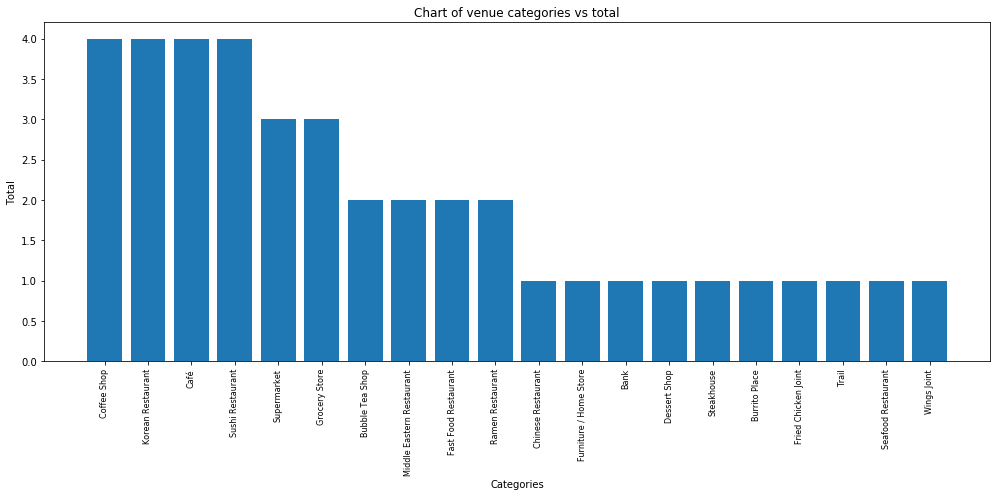

In [118]:
visualise_cat(c_0)

### Cluster 1

In [119]:
c_1 = df_cluster.loc[df_cluster['Cluster'] == 1]
get_common(c_1, 10)

[('Café', 27),
 ('Coffee Shop', 26),
 ('Bakery', 22),
 ('Italian Restaurant', 19),
 ('Park', 17),
 ('Bar', 15),
 ('Pizza Place', 9),
 ('Restaurant', 9),
 ('Gastropub', 8),
 ('Brewery', 8)]

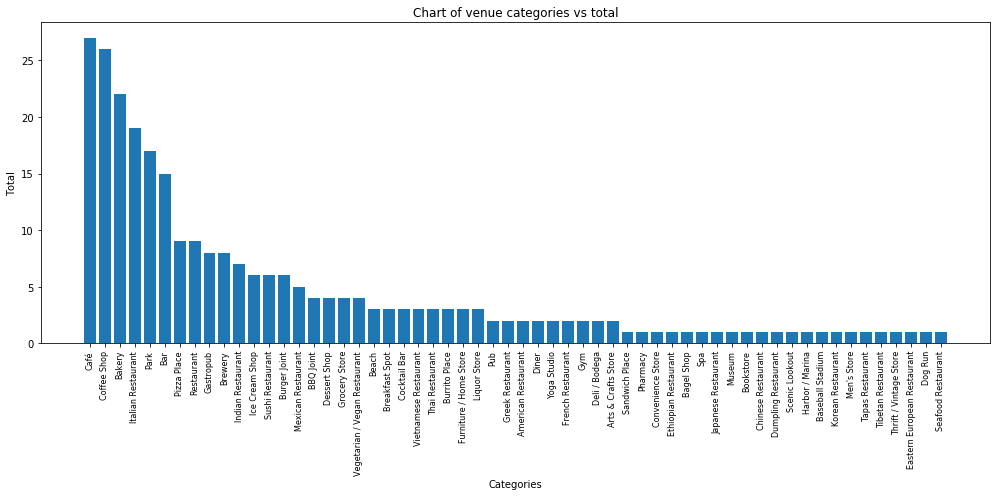

In [120]:
visualise_cat(c_1)

### Cluster 2

In [121]:
c_2 = df_cluster.loc[df_cluster['Cluster'] == 2]
get_common(c_2, 10)

[('Coffee Shop', 22),
 ('Café', 22),
 ('Italian Restaurant', 15),
 ('Japanese Restaurant', 13),
 ('Restaurant', 12),
 ('Sushi Restaurant', 11),
 ('Bakery', 11),
 ('Park', 8),
 ('Hotel', 8),
 ('Pizza Place', 6)]

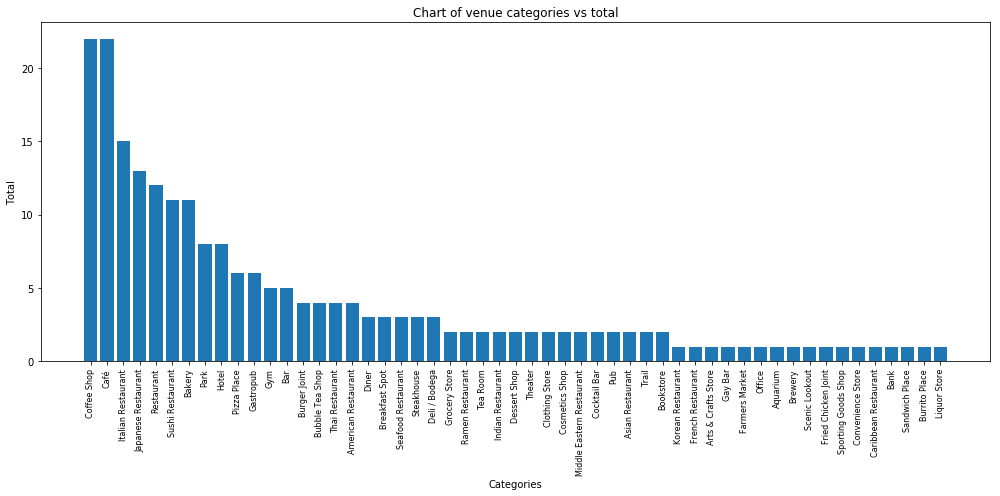

In [122]:
visualise_cat(c_2)

### Cluster 3

In [123]:
c_3 = df_cluster.loc[df_cluster['Cluster'] == 3]
get_common(c_3, 10)

[('Coffee Shop', 29),
 ('Burger Joint', 15),
 ('Bakery', 15),
 ('Japanese Restaurant', 15),
 ('Grocery Store', 14),
 ('Middle Eastern Restaurant', 11),
 ('Chinese Restaurant', 10),
 ('Park', 9),
 ('Supermarket', 9),
 ('Clothing Store', 9)]

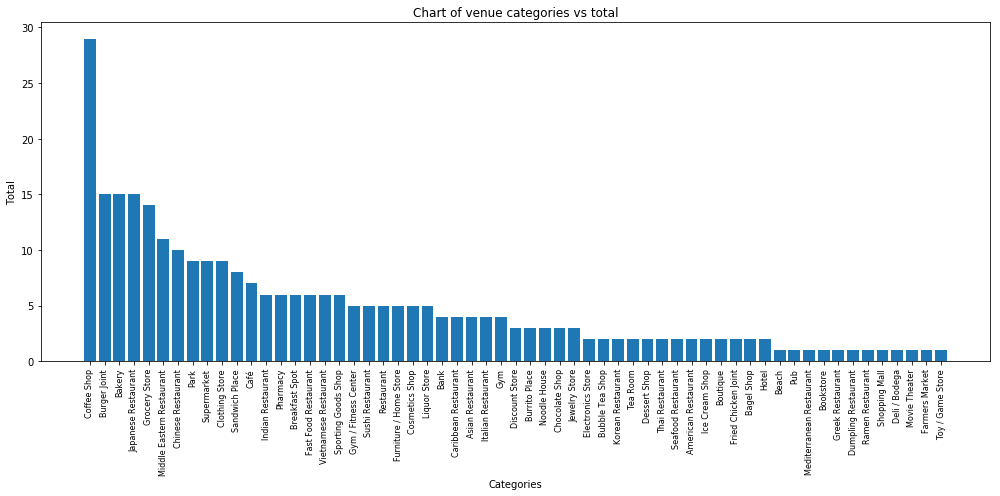

In [124]:
visualise_cat(c_3)

### Cluster 4

In [125]:
c_4 = df_cluster.loc[df_cluster['Cluster'] == 4]
get_common(c_4, 10)

[('Coffee Shop', 21),
 ('Pharmacy', 17),
 ('Sandwich Place', 16),
 ('Pizza Place', 15),
 ('Fast Food Restaurant', 13),
 ('Bank', 10),
 ('Indian Restaurant', 9),
 ('Chinese Restaurant', 9),
 ('Beer Store', 8),
 ('Park', 7)]

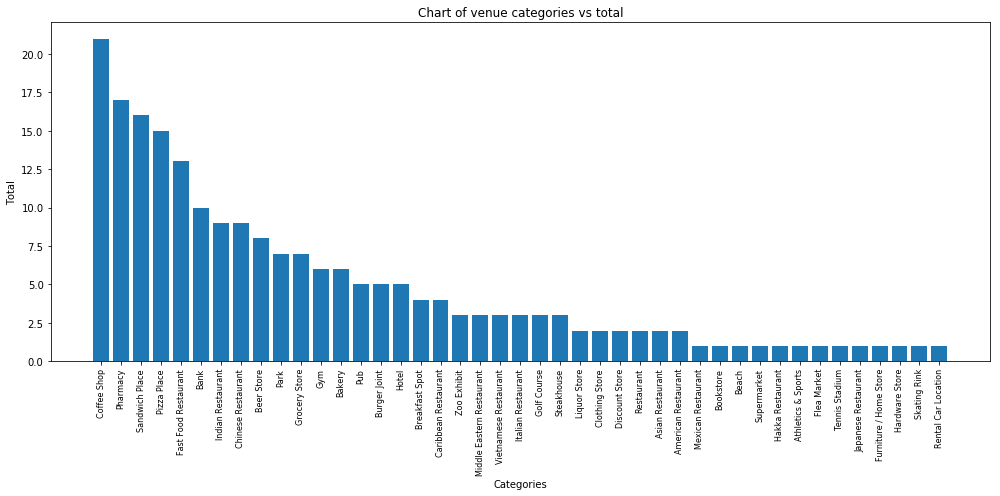

In [126]:
visualise_cat(c_4)